In [ ]:
!ls  # to see list of folders in drive

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [4]:
 ! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
! kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
arashnic/hr-analytics-job-change-of-data-scientists            HR Analytics: Job Change of Data Scientists        295KB  2020-12-07 00:25:10           1094  
babyoda/access-to-computers-from-home-oecd                     Access to Computers From Home OECD                   3KB  2020-12-04 10:50:09             80  
shashwatwork/impact-of-covid19-pandemic-on-the-global-economy  Impact of Covid-19 Pandemic on the Global Economy    1MB  2020-11-29 14:16:30            530  
emmanuelleai/world-marathons-majors                            World Marathons Majors                               7KB  2020-12-06 19:24:28            105  
mrmorj/dataset-of-songs-in-spotify                  

In [7]:
! kaggle datasets download -d mgornergoogle/five-flowers

 99% 0.98G/0.99G [00:09<00:00, 138MB/s]
100% 0.99G/0.99G [00:09<00:00, 111MB/s]


In [8]:
! mkdir flowerdata

In [9]:
! unzip five-flowers.zip -d flowerdata

Archive:  five-flowers.zip
  inflating: flowerdata/LICENSE.txt  
  inflating: flowerdata/original-jpegs/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowerdata/original-jpegs/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowerdata/original-jpegs/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowerdata/original-jpegs/daisy/10172567486_2748826a8b.jpg  
  inflating: flowerdata/original-jpegs/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowerdata/original-jpegs/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowerdata/original-jpegs/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowerdata/original-jpegs/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowerdata/original-jpegs/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowerdata/original-jpegs/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowerdata/original-jpegs/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowerdata/original-jpegs/daisy/10466290366_cc72e33532.jpg  
  inflating: flowerdata/original-jpegs/d

In [10]:
import re
import tensorflow as tf
import tensorflow_hub as tfhub
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.0


In [11]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


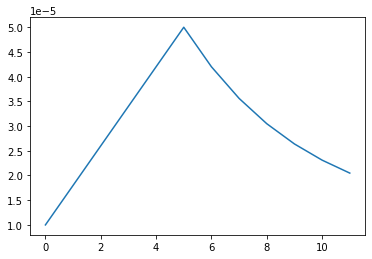

In [12]:
EPOCHS = 12
IMAGE_SIZE = [331, 331]

FLOWERS_DATASETS = { # available image sizes
    192: '/content/flowerdata/tfrecords-jpeg-192x192/*.tfrec',
    224: '/content/flowerdata/tfrecords-jpeg-224x224/*.tfrec',
    331: '/content/flowerdata/tfrecords-jpeg-331x331/*.tfrec',
    512: '/content/flowerdata/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [13]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()  

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)



In [14]:
gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]
TRAIN_STEPS = count_data_items(TRAINING_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAINING_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALIDATION_FILENAMES))

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  186
VALIDATION IMAGES:  680


In [15]:
def to_float32(image, label):
    return tf.cast(image, tf.float32), label
        
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3) # pixel format uint8 [0,255] range
    class_label = tf.cast(example['class'], tf.int32) # not used
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def force_image_sizes(dataset, image_size):
    # explicit size needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [16]:
validation_dataset = get_validation_dataset()    

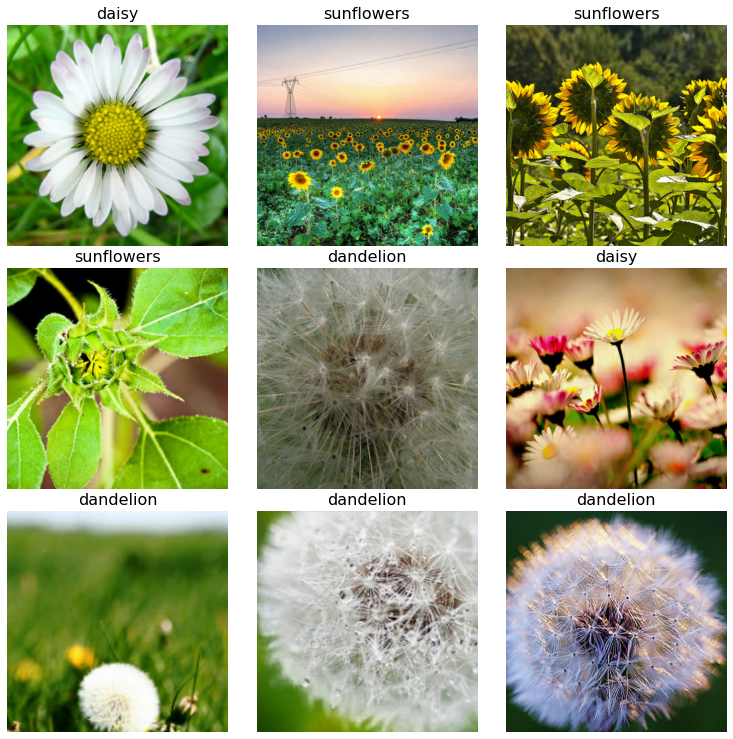

In [17]:
display_9_images_from_dataset(validation_dataset)     

In [18]:
def create_model():
    #img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNetV2(include_top=False)
    
    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = tf.keras.applications.Xception(include_top=False)
    
    # available in TF 2.3 only
    #img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.EfficientNetB0(include_top=False)
    
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
with strategy.scope():
    model = create_model()
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [21]:
# TPUs need images in float format
training_dataset = get_training_dataset().map(to_float32)
validation_dataset = get_validation_dataset().map(to_float32)

history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
186/186 [==============================] - 157s 712ms/step - loss: 1.4170 - accuracy: 0.4568 - val_loss: 0.7850 - val_accuracy: 0.8397
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
186/186 [==============================] - 135s 724ms/step - loss: 0.6279 - accuracy: 0.8657 - val_loss: 0.2787 - val_accuracy: 0.9382
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
186/186 [==============================] - 137s 737ms/step - loss: 0.2962 - accuracy: 0.9209 - val_loss: 0.1735 - val_accuracy: 0.9559
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
186/186 [==============================] - 137s 736ms/step - loss: 0.1983 - accuracy: 0.9427 - val_loss: 0.1385 - val_accuracy: 0.9588
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 4.20000000000000

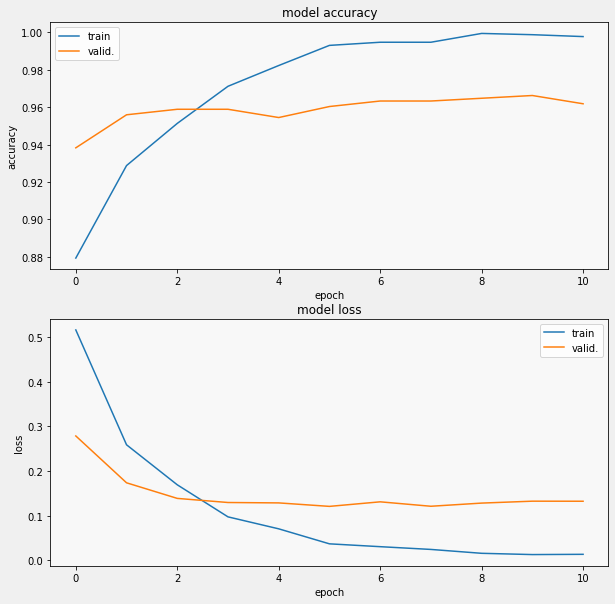

In [22]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [23]:
# a couple of images to test predictions too
some_flowers, some_labels = dataset_to_numpy_util(get_validation_dataset(), 160)

10/10 [==============================] - 3s 136ms/step - loss: 0.0844 - accuracy: 0.9563
['daisy', 'daisy', 'tulips', 'daisy', 'tulips', 'tulips', 'sunflowers', 'tulips', 'roses', 'daisy', 'roses', 'daisy', 'daisy', 'roses', 'daisy', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion', 'dandelion', 'roses', 'daisy', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'roses', 'daisy', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'daisy', 'dandelion', 'roses', 'sunflowers', 'roses', 'tulips', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'roses', 'daisy', 'sunflowers', 'sunflowers', 'roses', '

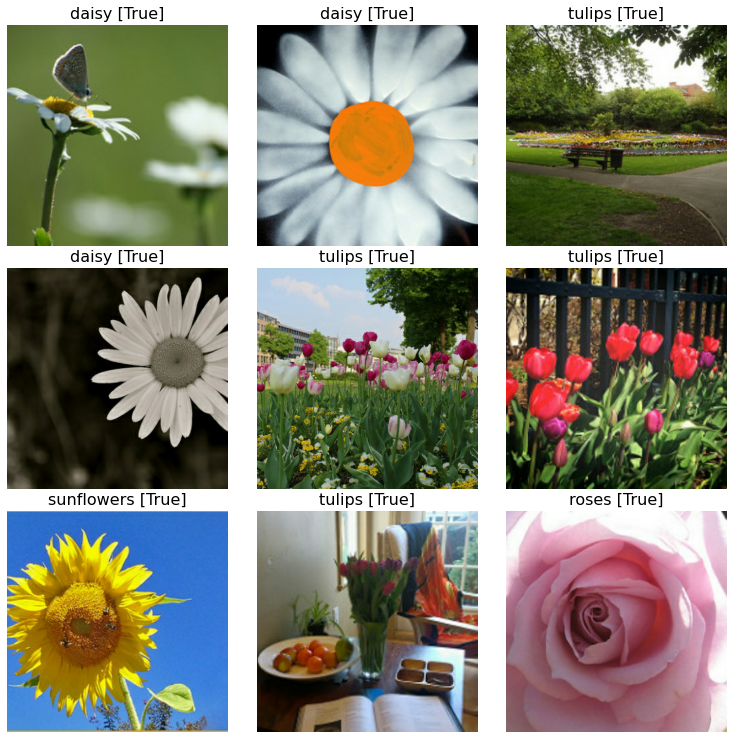

In [24]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

# tf.cast ?
predictions = model.predict(tf.cast(some_flowers, tf.float32), batch_size=16)
evaluations = model.evaluate(tf.cast(some_flowers, tf.float32), some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

display_9_images_with_predictions(some_flowers, predictions, some_labels)

In [25]:
model.save('model.h5')

10/10 [==============================] - 2s 132ms/step - loss: 0.0844 - accuracy: 0.9563
['daisy', 'daisy', 'tulips', 'daisy', 'tulips', 'tulips', 'sunflowers', 'tulips', 'roses', 'daisy', 'roses', 'daisy', 'daisy', 'roses', 'daisy', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion', 'dandelion', 'roses', 'daisy', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'roses', 'daisy', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'daisy', 'dandelion', 'roses', 'sunflowers', 'roses', 'tulips', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'roses', 'daisy', 'sunflowers', 'sunflowers', 'roses', '

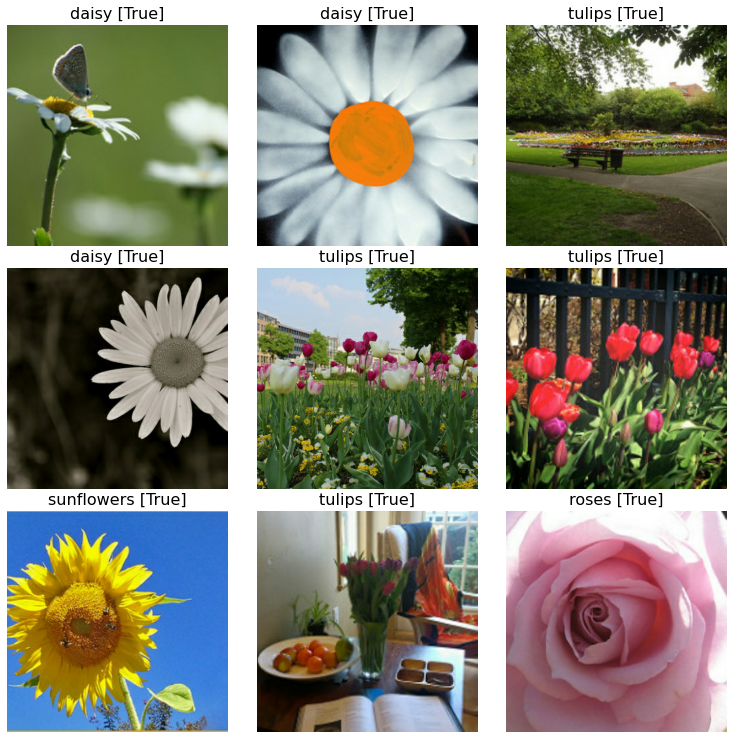

In [26]:
reload_model = tf.keras.models.load_model('model.h5')

predictions = reload_model.predict(some_flowers, batch_size=16)
evaluations = reload_model.evaluate(some_flowers, some_labels, batch_size=16)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)
display_9_images_with_predictions(some_flowers, predictions, some_labels)